In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Deps
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer


## Load the data

In [3]:
# Load and preprocess the data
train_df = pd.read_csv('train.csv')
train_df.head()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


## EDA

In [4]:
def print_df(df):
    # Print the shape of the DataFrame
    print("Shape of the DataFrame:", df.shape)
    # Print the columns of the DataFrame
    print("Columns in the DataFrame:", df.columns)


print_df(train_df)

Shape of the DataFrame: (5237980, 17)
Columns in the DataFrame: Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')


In [5]:
# Available Stocks count
len(train_df.stock_id.unique())

200

<Axes: >

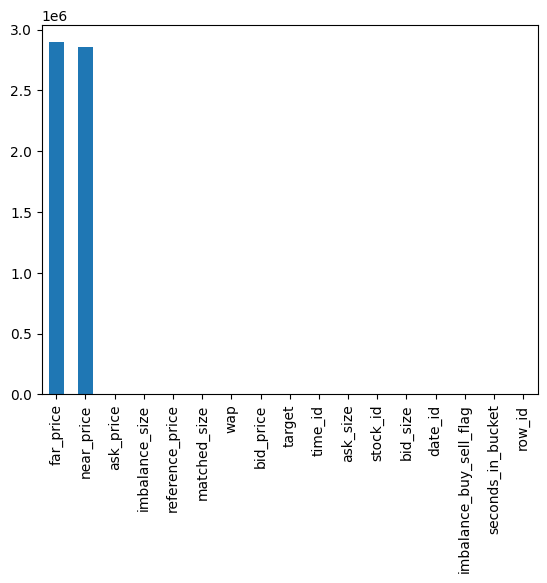

In [6]:
train_df.isna().sum().sort_values(ascending=False).plot(kind='bar')

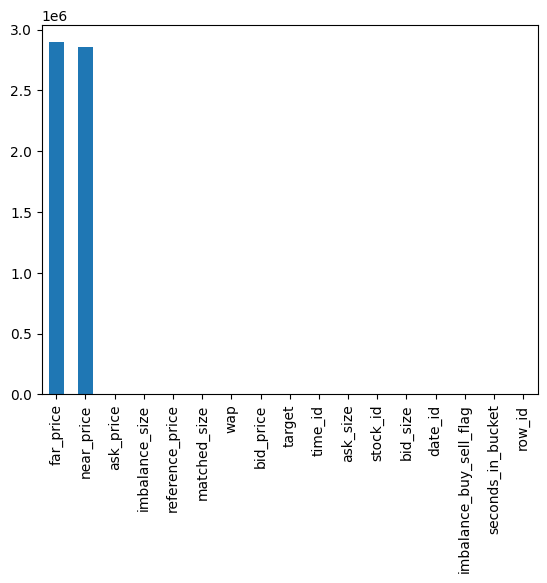

In [7]:
# Check the total null values of df
def check_null(df,return_null_cols=False, null_cols_count=2, ):
    df = df.copy()
    vals = df.isna().sum().sort_values(ascending=False).plot(kind='bar')
    if return_null_cols:
        return vals[:null_cols_count].index

null_cols = check_null(train_df)

In [8]:
null_cols

In [9]:
# Drip high null columsn
high_null_cols = train_df.isna().sum().sort_values(ascending=False)[:2].index

print(f"high null values: {high_null_cols}")

def drop_cols(df, cols):
    df = df.drop(cols, axis=1)
    return df

df = drop_cols(train_df, high_null_cols)
df = drop_cols(df, ['row_id'])

high null values: Index(['far_price', 'near_price'], dtype='object')


In [10]:
def imputer(df_processed):
    '''
    Function that receives a dataframe and returns the median value of each missing value in a column partitioned by stock_id,
    '''
    stock_list = list(df_processed['stock_id'].unique())

    imputer_columns = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 
                       'wap', 'target', 'seconds_in_bucket', 'bid_size', 'ask_size']

    # Create a single SimpleImputer instance for each column
    imputers = {col: SimpleImputer(missing_values=np.nan, strategy='median') for col in imputer_columns}

    for stock in stock_list:
        stock_df = df_processed.loc[df_processed['stock_id'] == stock]

        # Apply imputation to each column
        for col, imputer in imputers.items():
            stock_df.loc[:,col] = imputer.fit_transform(stock_df[col].values.reshape(-1,1))

        # Update the original DataFrame with imputed values
        df_processed.loc[df_processed['stock_id'] == stock, imputer_columns] = stock_df[imputer_columns].values

    return df_processed, imputers

df_processed, imputers = imputer(df)

In [11]:
imputers

{'imbalance_size': SimpleImputer(strategy='median'),
 'reference_price': SimpleImputer(strategy='median'),
 'matched_size': SimpleImputer(strategy='median'),
 'bid_price': SimpleImputer(strategy='median'),
 'ask_price': SimpleImputer(strategy='median'),
 'wap': SimpleImputer(strategy='median'),
 'target': SimpleImputer(strategy='median'),
 'seconds_in_bucket': SimpleImputer(strategy='median'),
 'bid_size': SimpleImputer(strategy='median'),
 'ask_size': SimpleImputer(strategy='median')}

In [12]:
def apply_imputer(df_processed, imputers):
    imputer_columns = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price',
                       'wap', 'seconds_in_bucket', 'bid_size', 'ask_size']

    for col in imputer_columns:
        df_processed[col] = imputers[col].transform(np.array(df_processed[col]).reshape(-1, 1))

    return df_processed

In [13]:
df_processed = apply_imputer(df_processed, imputers)

In [14]:
### Test dataset:
test_df = pd.read_csv("example_test_files/test.csv")
test_df_targets = pd.read_csv("example_test_files/revealed_targets.csv")

sample_submission = pd.read_csv("example_test_files/sample_submission.csv")
test_df


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0,False
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.000000,26290,478_0_1,False
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.000000,26290,478_0_2,False
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.000000,26290,478_0_3,False
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.000000,26290,478_0_4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195,False
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196,False
32997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,26454,480_540_197,False
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198,False


## PreProcessing for X Train y Train

In [15]:

y = df_processed['target']
X = df_processed.drop(['target'], axis = 1)

In [16]:
X = X.drop(['time_id'], axis = 1)


In [17]:
# Use this same cols to test data
X_cols = X.columns

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)

## Building model

In [19]:
# Train the model
clf = xgb.XGBRegressor(n_estimators = 20, eval_metric = 'mae')


In [20]:
clf.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
y_pred = clf.predict(X_test)
y_pred

array([-0.46447706,  0.08227   , -0.44877222, ..., -0.3378636 ,
       -0.02125105, -1.5965672 ], dtype=float32)

## Evaluation

In [22]:
mae = mean_absolute_error(y_pred, y_test)
print("Mean Absolute Error: {}".format(mae))

Mean Absolute Error: 6.317359829963602


### Prediction on the real test data

In [23]:

test_preds = clf.predict(test_df[X_cols])
test_preds

array([-2.033901  ,  1.4639628 ,  2.425465  , ...,  0.72875226,
        1.657935  , -1.4829203 ], dtype=float32)

In [24]:
# pd.DataFrame({'row_id':sample_submission["row_id"],'target':test_preds}).to_csv('submission.csv', index=False)

In [25]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

ModuleNotFoundError: No module named 'optiver2023.competition'

In [ ]:
revealed = pd.read_csv('example_test_files/revealed_targets.csv')
test = pd.read_csv('example_test_files/test.csv')


In [ ]:
counter = 0
for (test, revealed_targets, test_preds) in iter_test:
    if counter == 0:
        print(test.head(3))
        print(revealed_targets.head(3))
        print(test_preds.head(3))
    test_preds['target'] = 0
    env.predict(test_preds)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0      478                  0      3753451.43   
1         1      478                  0       985977.11   
2         2      478                  0       599128.74   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                       -1         0.999875   11548975.43        NaN   
1                       -1         1.000245    3850033.97        NaN   
2                        1         1.000584    4359198.25        NaN   

   near_price  bid_price  bid_size  ask_price  ask_size  wap   row_id  \
0         NaN   0.999875  22940.00   1.000050   9177.60  1.0  478_0_0   
1         NaN   0.999940   1967.90   1.000601  19692.00  1.0  478_0_1   
2         NaN   0.999918   4488.22   1.000636  34955.12  1.0  478_0_2   

   currently_scored  
0             False  
1           

In [22]:
train_df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [23]:
df_processed.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715081e+06,-1.189619e-02,9.999955e-01,4.509861e+07,9.997263e-01,5.181359e+04,1.000265e+00,5.357568e+04,9.999920e-01,-4.756155e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051550e+07,8.853374e-01,2.532444e-03,1.398386e+08,2.499293e-03,1.114214e+05,2.509991e-03,1.293554e+05,2.497456e-03,9.452780e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.456663e+04,-1.000000e+00,9.987630e-01,5.279384e+06,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113467e+06,0.000000e+00,9.999670e-01,1.288158e+07,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190639e+06,1.000000e+00,1.001174e+00,3.269849e+07,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [24]:
df_processed.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
0,0,0,0.0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0
1,1,0,0.0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0
2,2,0,0.0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0
3,3,0,0.0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0
4,4,0,0.0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0


In [25]:
train_df[0:10]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001,0,0_0_8
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.0,7.970333,0,0_0_9


In [26]:
def add_seconds_to_row_id(row_id, seconds):
    row_split = row_id.split("_")
    return row_split[0] + '_' + str(int(row_split[1]) + 60) + '_' + row_split[2]

In [27]:
train_df_2 = train_df.copy()

In [28]:
train_df_2['row_id_60_secs_to_future'] = train_df_2.apply(lambda row: \
          add_seconds_to_row_id(row.row_id, 60), axis=1)
train_df_60_secs_to_future = train_df[["row_id", "wap"]].copy()
train_df_60_secs_to_future.columns = train_df_60_secs_to_future.columns.map(lambda col: \
                              col+'_60_secs_to_future')
train_df_2 = pd.merge(train_df_2, train_df_60_secs_to_future, \
                            on=['row_id_60_secs_to_future'], how='left')

In [29]:
train_df_2.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,row_id_60_secs_to_future,wap_60_secs_to_future
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,0_60_0,1.000517
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,0_60_1,1.000268
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,0_60_2,0.999981
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,0_60_3,1.000419
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,0_60_4,1.000086


In [30]:
train_df_2["index_diff"]=(train_df_2["wap_60_secs_to_future"]/train_df_2["wap"])-train_df_2["target"]/10000

In [31]:
train_df_2.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,row_id_60_secs_to_future,wap_60_secs_to_future,index_diff
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,0_60_0,1.000517,1.000820
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,0_60_1,1.000268,1.000820
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,0_60_2,0.999981,1.000820
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,0_60_3,1.000419,1.000820
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,0_60_4,1.000086,1.000821


In [32]:
train_df_2["index_diff"].describe()

count    4.666368e+06
mean     1.000007e+00
std      6.493229e-04
min      9.948220e-01
25%      9.996830e-01
50%      1.000000e+00
75%      1.000324e+00
max      1.006878e+00
Name: index_diff, dtype: float64

In [33]:
train_df_2["wap_diff"] = train_df_2["wap_60_secs_to_future"]/train_df_2["wap"]
train_df_2.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_price,ask_size,wap,target,time_id,row_id,row_id_60_secs_to_future,wap_60_secs_to_future,index_diff,wap_diff
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,1.000026,8493.03,1.0,-3.029704,0,0_0_0,0_60_0,1.000517,1.000820,1.000517
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,1.000660,20605.09,1.0,-5.519986,0,0_0_1,0_60_1,1.000268,1.000820,1.000268
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,...,1.000298,18995.00,1.0,-8.389950,0,0_0_2,0_60_2,0.999981,1.000820,0.999981
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,1.000214,479032.40,1.0,-4.010200,0,0_0_3,0_60_3,1.000419,1.000820,1.000419
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,1.000016,434.10,1.0,-7.349849,0,0_0_4,0_60_4,1.000086,1.000821,1.000086


In [34]:
train_df_2["wap_diff"].describe()

count    4.666368e+06
mean     1.000002e+00
std      1.113927e-03
min      9.607158e-01
25%      9.994557e-01
50%      9.999990e-01
75%      1.000538e+00
max      1.037969e+00
Name: wap_diff, dtype: float64

<Axes: ylabel='Frequency'>

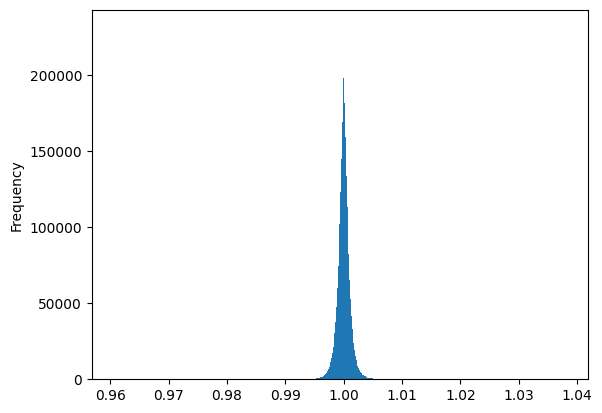

In [35]:
train_df_2["wap_diff"].plot.hist(bins=1000)

<Axes: ylabel='Frequency'>

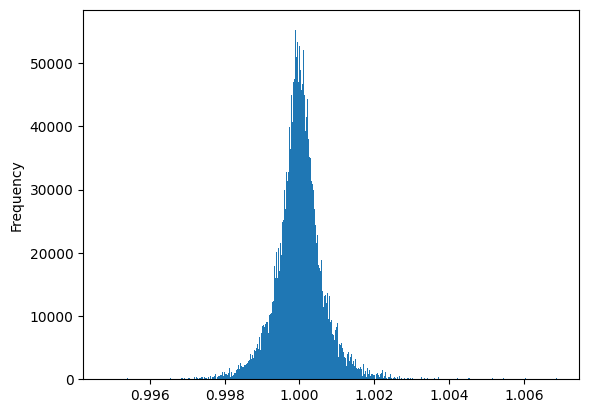

In [36]:
train_df_2["index_diff"].plot.hist(bins=1000)

In [37]:
train_df_2[["index_diff", "date_id"]].groupby('date_id').agg(['min', 'max'])

index_diff          
               min       max
date_id                     
0         0.999299  1.000821
1         0.999653  1.000684
2         0.999454  1.000273
3         0.999772  1.000399
4         0.999782  1.000516
...            ...       ...
476       0.999341  1.000440
477       0.998811  1.000902
478       0.999167  1.001326
479       0.998932  1.000805
480       0.999359  1.000142

[481 rows x 2 columns]

In [38]:
y = train_df_2.dropna()['index_diff']
X = train_df_2.dropna().drop(['index_diff','target', 'row_id','far_price', 'near_price','row_id_60_secs_to_future', 'wap_60_secs_to_future','wap_diff','time_id'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)

In [39]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
model1 = LinearRegression()
model1.fit(X_train,y_train)
train_pred = model1.predict(X_train)
print("train error:",mean_absolute_error(train_pred, y_train))
print("test error:",mean_absolute_error(model1.predict(X_test), y_test))

train error: 0.0003744227625033454
test error: 0.0003743693853894618


In [40]:
X.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap
5730,0,0,300,0.00,0,1.000241,26670118.88,1.000026,19319.31,1.000241,16149.55,1.000143
5731,1,0,300,242332.96,-1,1.000073,3242054.27,0.999544,43205.40,1.000308,2042.76,1.000273
5732,2,0,300,0.00,0,1.000193,4671376.00,0.999035,18971.00,1.001036,59688.26,0.999518
5733,3,0,300,2914730.16,1,0.999870,41057776.66,0.999827,25569.50,1.000042,37897.50,0.999914
5734,4,0,300,3396923.02,1,0.998496,38356174.88,0.998357,14446.00,0.998703,2601.18,0.998650


In [41]:
y = train_df_2.dropna()['wap_60_secs_to_future']
X = train_df_2.dropna().drop(['target', 'row_id','far_price', 'near_price','row_id_60_secs_to_future', 'wap_60_secs_to_future','wap_diff','time_id','index_diff'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)

In [42]:
model2 = LinearRegression()
model2.fit(X_train,y_train)
train_pred = model2.predict(X_train)
print("train error:",mean_absolute_error(train_pred, y_train))
print("test error:",mean_absolute_error(model2.predict(X_test), y_test))

train error: 0.0006498185774148982
test error: 0.0006495105735453557


In [43]:
y = df_processed['target']
X = df_processed.drop(['target'], axis = 1)
X = X.drop(['time_id'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)
X_test["index_diff"] = model1.predict(X_test)
X_test["wap_60_secs_to_future"] = model2.predict(X_test.drop(['index_diff'],axis=1))
X_test["target_pred"] = 10000*(X_test["wap_60_secs_to_future"]/X_test["wap"]-X_test["index_diff"])

In [44]:
print(mean_absolute_error(X_test["target_pred"],y_test))

6.322815095736363


In [46]:
from sklearn.metrics import mean_absolute_error

def conj_model_eval(model1, model2, X_test, y_test):
    X_test["index_diff"] = model1.predict(X_test)
    X_test["wap_60_secs_to_future"] = model2.predict(X_test.drop(['index_diff'],axis=1))
    X_test["target_pred"] = 10000*(X_test["wap_60_secs_to_future"]/X_test["wap"]-X_test["index_diff"])
    mae = mean_absolute_error(X_test["target_pred"],y_test)
    print("model1:",type(model1).__name__,"; model2:",type(model2).__name__,"; MAE:",mae)
    return mae

def train_and_eval_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    train_mae = mean_absolute_error(model.predict(X_train), y_train)
    val_mae = mean_absolute_error(model.predict(X_val), y_val)
    print("model:", type(model).__name__,"; train MAE:",train_mae,"; val MAE:", val_mae)
    return train_mae, val_mae

def train_and_eval_model1(model, train_df_2):
    y = train_df_2.dropna()['index_diff']
    X = train_df_2.dropna().drop(['index_diff','target', 'row_id','far_price', 'near_price','row_id_60_secs_to_future', 'wap_60_secs_to_future','wap_diff','time_id'], axis = 1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.8)
    return train_and_eval_model(model, X_train, y_train, X_val, y_val)

def train_and_eval_model2(model, train_df_2):
    y = train_df_2.dropna()['wap_60_secs_to_future']
    X = train_df_2.dropna().drop(['index_diff','target', 'row_id','far_price', 'near_price','row_id_60_secs_to_future', 'wap_60_secs_to_future','wap_diff','time_id'], axis = 1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.8)
    return train_and_eval_model(model, X_train, y_train, X_val, y_val)

In [53]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
models_1_1 = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), SGDRegressor(), SVR()]
for model in models_1_1:
    train_and_eval_model1(model, train_df_2)

model: LinearRegression ; train MAE: 0.0003747617402781441 ; val MAE: 0.0003743325735416463
model: Lasso ; train MAE: 0.00037451097521314086 ; val MAE: 0.0003750867715618286


C:\Users\Erki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.46968e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


model: Ridge ; train MAE: 0.0003747863204072778 ; val MAE: 0.00037431138538955485
model: ElasticNet ; train MAE: 0.0003755728208052166 ; val MAE: 0.0003748121913239221
model: SGDRegressor ; train MAE: 6.142462734853487e+24 ; val MAE: 6.148173385371777e+24
model: SVR ; train MAE: 0.00038914417122272877 ; val MAE: 0.0003894121050615097


In [55]:
models_1_2 = [KNeighborsRegressor(n_neighbors=7),
          DecisionTreeRegressor(), RandomForestRegressor(n_estimators=33), MLPRegressor((32,32,32))]
for model in models_1_2:
    train_and_eval_model1(model, train_df_2)

model: KNeighborsRegressor ; train MAE: 0.00034802644047627734 ; val MAE: 0.0004010669126595859
model: DecisionTreeRegressor ; train MAE: 2.3618247563774143e-09 ; val MAE: 3.1758868061460024e-06
model: RandomForestRegressor ; train MAE: 2.075200916128269e-06 ; val MAE: 5.366105651090457e-06
model: MLPRegressor ; train MAE: 0.00037507876586931533 ; val MAE: 0.0003749665917416765


In [56]:
models_2_1 = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), SGDRegressor(), SVR()]
for model in models_2_1:
    train_and_eval_model2(model, train_df_2)

model: LinearRegression ; train MAE: 0.0006501879199477049 ; val MAE: 0.0006493336848575476
model: Lasso ; train MAE: 0.002250211039692498 ; val MAE: 0.002247146618374388


C:\Users\Erki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.82266e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


model: Ridge ; train MAE: 0.0006779486658779691 ; val MAE: 0.0006771933397436454
model: ElasticNet ; train MAE: 0.002248276227876671 ; val MAE: 0.002247917637332683
model: SGDRegressor ; train MAE: 2.4085236365010772e+23 ; val MAE: 2.4050108257496663e+23
model: SVR ; train MAE: 0.009395619035192962 ; val MAE: 0.009399958425576432


In [57]:
models_2_2 = [KNeighborsRegressor(n_neighbors=7),
          DecisionTreeRegressor(), RandomForestRegressor(n_estimators=33), MLPRegressor((32,32,32))]
for model in models_2_2:
    train_and_eval_model2(model, train_df_2)

model: KNeighborsRegressor ; train MAE: 0.0019625928147260032 ; val MAE: 0.0022772426453512187
model: DecisionTreeRegressor ; train MAE: 9.396061989915988e-22 ; val MAE: 0.0009274522897546591
model: RandomForestRegressor ; train MAE: 0.0002454005601967905 ; val MAE: 0.0006430664396861445
model: MLPRegressor ; train MAE: 0.0060005301827127785 ; val MAE: 0.0037905325971501922


In [59]:
for model1 in models_1_1:
    for model2 in models_2_1:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)
        conj_model_eval(model1, model2, X_test, y_test)

model1: LinearRegression ; model2: LinearRegression ; MAE: 6.3227736694546195
model1: LinearRegression ; model2: Lasso ; MAE: 18.495766800819663
model1: LinearRegression ; model2: Ridge ; MAE: 6.535493107539132
model1: LinearRegression ; model2: ElasticNet ; MAE: 18.494685350254738
model1: LinearRegression ; model2: SGDRegressor ; MAE: 2.5327923580420775e+27
model1: LinearRegression ; model2: SVR ; MAE: 94.39222434108952
model1: Lasso ; model2: LinearRegression ; MAE: 6.4026852125822735
model1: Lasso ; model2: Lasso ; MAE: 18.431322682593194
model1: Lasso ; model2: Ridge ; MAE: 6.601321636673705
model1: Lasso ; model2: ElasticNet ; MAE: 18.429999800167895
model1: Lasso ; model2: SGDRegressor ; MAE: 2.5327923580420775e+27
model1: Lasso ; model2: SVR ; MAE: 93.70445897266121
model1: Ridge ; model2: LinearRegression ; MAE: 6.323054897318607
model1: Ridge ; model2: Lasso ; MAE: 18.495127791952815
model1: Ridge ; model2: Ridge ; MAE: 6.537179880363697
model1: Ridge ; model2: ElasticNet ; MA

In [60]:
for model1 in models_1_1:
    for model2 in models_2_2:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)
        conj_model_eval(model1, model2, X_test, y_test)

model1: LinearRegression ; model2: KNeighborsRegressor ; MAE: 22.173350403580912
model1: LinearRegression ; model2: DecisionTreeRegressor ; MAE: 10.1147090113305
model1: LinearRegression ; model2: RandomForestRegressor ; MAE: 6.485408786912315
model1: LinearRegression ; model2: MLPRegressor ; MAE: 83.80070950493322
model1: Lasso ; model2: KNeighborsRegressor ; MAE: 22.120349918400642
model1: Lasso ; model2: DecisionTreeRegressor ; MAE: 10.100825243572316
model1: Lasso ; model2: RandomForestRegressor ; MAE: 6.468598491655755
model1: Lasso ; model2: MLPRegressor ; MAE: 83.72050363759365
model1: Ridge ; model2: KNeighborsRegressor ; MAE: 22.17399939976935
model1: Ridge ; model2: DecisionTreeRegressor ; MAE: 10.113107055349102
model1: Ridge ; model2: RandomForestRegressor ; MAE: 6.482716830487791
model1: Ridge ; model2: MLPRegressor ; MAE: 83.80082090319468
model1: ElasticNet ; model2: KNeighborsRegressor ; MAE: 22.12030628453981
model1: ElasticNet ; model2: DecisionTreeRegressor ; MAE: 10

In [61]:
for model1 in models_1_2:
    for model2 in models_2_1:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)
        conj_model_eval(model1, model2, X_test, y_test)

model1: KNeighborsRegressor ; model2: LinearRegression ; MAE: 6.680285649673162
model1: KNeighborsRegressor ; model2: Lasso ; MAE: 18.550270050535968
model1: KNeighborsRegressor ; model2: Ridge ; MAE: 6.870877326007919
model1: KNeighborsRegressor ; model2: ElasticNet ; MAE: 18.549232919660422
model1: KNeighborsRegressor ; model2: SGDRegressor ; MAE: 2.5327923580420775e+27
model1: KNeighborsRegressor ; model2: SVR ; MAE: 93.7786398130563
model1: DecisionTreeRegressor ; model2: LinearRegression ; MAE: 7.996223791036327
model1: DecisionTreeRegressor ; model2: Lasso ; MAE: 19.293778469170537
model1: DecisionTreeRegressor ; model2: Ridge ; MAE: 8.204452876118047
model1: DecisionTreeRegressor ; model2: ElasticNet ; MAE: 19.292314422830213
model1: DecisionTreeRegressor ; model2: SGDRegressor ; MAE: 2.5327923580420775e+27
model1: DecisionTreeRegressor ; model2: SVR ; MAE: 93.84711967679698
model1: RandomForestRegressor ; model2: LinearRegression ; MAE: 7.981588055945018
model1: RandomForestReg

In [62]:
for model1 in models_1_2:
    for model2 in models_2_2:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)
        conj_model_eval(model1, model2, X_test, y_test)

model1: KNeighborsRegressor ; model2: KNeighborsRegressor ; MAE: 22.137897286116583
model1: KNeighborsRegressor ; model2: DecisionTreeRegressor ; MAE: 10.266295190024184
model1: KNeighborsRegressor ; model2: RandomForestRegressor ; MAE: 6.729761638024003
model1: KNeighborsRegressor ; model2: MLPRegressor ; MAE: 83.8426400414093
model1: DecisionTreeRegressor ; model2: KNeighborsRegressor ; MAE: 22.74835200261728
model1: DecisionTreeRegressor ; model2: DecisionTreeRegressor ; MAE: 10.80982149805944
model1: DecisionTreeRegressor ; model2: RandomForestRegressor ; MAE: 7.8203232774159765
model1: DecisionTreeRegressor ; model2: MLPRegressor ; MAE: 84.58296639617214
model1: RandomForestRegressor ; model2: KNeighborsRegressor ; MAE: 22.742777146878048
model1: RandomForestRegressor ; model2: DecisionTreeRegressor ; MAE: 10.802201448879934
model1: RandomForestRegressor ; model2: RandomForestRegressor ; MAE: 7.806045775085514
model1: RandomForestRegressor ; model2: MLPRegressor ; MAE: 84.57566567

In [63]:
models_1_1[0].coef_

array([-1.16184111e-09, -6.95740663e-08,  5.72492027e-07, -2.16131248e-13,
        8.60962115e-06,  3.09632964e-04,  2.10459765e-14, -1.03881880e-02,
       -1.88526115e-12,  1.76140092e-03, -1.91167417e-11,  1.05814780e-02])

In [64]:
from joblib import dump, load
dump(models_1_1[0], "index_diff_model_linear_regression.joblib")
dump(models_2_1[0], "wap_60_secs_to_future_model_linear_regression.joblib")

['wap_60_secs_to_future_model_linear_regression.joblib']

In [1]:
dump(models_1_2[2], "index_diff_model_random_forest.joblib")

NameError: name 'dump' is not defined